In [1]:
import pandas as pd
from PIL import Image
import numpy as np 
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import directed_hausdorff
import seaborn as sns
from scipy.stats import norm
from skimage import exposure
from skimage import io
from sklearn.metrics.cluster import adjusted_rand_score 
from sklearn.metrics import normalized_mutual_info_score ,mean_absolute_error
import warnings
from sklearn.metrics import jaccard_score
warnings.filterwarnings("ignore")
sns.set()

In [2]:
def Dice (im,gt):
    true_mask = np.asarray(gt).astype(np.bool)
    pred_mask = np.asarray(im).astype(np.bool)
    im_sum = true_mask.sum() + pred_mask.sum()
    if im_sum == 0:
        return (-1)
    intersection = np.logical_and(true_mask, pred_mask)
    return (2. * intersection.sum() / im_sum)

In [3]:
def jaccard_sc (im,gt):
    BW1 = cv2.threshold(im, 0.5, 1 , cv2.THRESH_BINARY)[1].ravel()
    BW2 = (cv2.threshold(gt, 128, 255, cv2.THRESH_BINARY)[1]/255).astype('int').ravel()
    return(jaccard_score(BW2,BW1))

In [4]:
def Volumetric_Similarity (im, gt) :
    true_mask = np.asarray(gt).astype(np.bool)
    pred_mask = np.asarray(im).astype(np.bool)
    im_sum = true_mask.sum() + pred_mask.sum()
    im_sous = pred_mask.sum() -  true_mask.sum()
    if im_sum == 0:
        return (-1)
    return(1-(abs(im_sous / im_sum)))

In [5]:
def ad_rand_sc(im,gt):
    BW1 = cv2.threshold(im, 0.5, 1 , cv2.THRESH_BINARY)[1].ravel()
    BW2 = (cv2.threshold(gt, 128, 255, cv2.THRESH_BINARY)[1]/255).astype('int').ravel()
    return(adjusted_rand_score(BW2,BW1))

In [6]:
def mu_normalized (im,gt):
    BW1 = cv2.threshold(im, 0.5, 1 , cv2.THRESH_BINARY)[1].ravel()
    BW2 = (cv2.threshold(gt, 128, 255, cv2.THRESH_BINARY)[1]/255).astype('int').ravel()
    return(normalized_mutual_info_score(BW2,BW1))

In [7]:
def huasdorf (im ,gt):
    BW1 = cv2.threshold(im, 0.5, 1 , cv2.THRESH_BINARY)[1]
    BW2 = (cv2.threshold(gt, 128, 255, cv2.THRESH_BINARY)[1]/255).astype('int')
    return(directed_hausdorff(BW1, BW2)[0])

In [8]:
def GCE (im,gt,p):
    BW1 = cv2.threshold(im, 0.5, 1 , cv2.THRESH_BINARY)[1]
    BW2 = (cv2.threshold(gt, 128, 255, cv2.THRESH_BINARY)[1]/255).astype('int')
    iter = 256 - ((256 // p) * p)
    E = 0
    for i in range(iter):
        for j in range (iter):
            S1 = BW1[(i*p):(i*p+p),(j*p):(j*p+p)].ravel().sum()
            S2 = BW2[(i*p):(i*p+p),(j*p):(j*p+p)].ravel().sum()
            if S1 > S2 :
                E+=(S1-S2)/p**2
            else :
                E+=(S2-S1)/p**2
                
    return(E /(iter*iter))

In [9]:
def performance (path,T) :   

    m_Dice = []
    m_jaccard_sc=[]
    m_Volumetric_Similarity=[]
    m_ad_rand_sc=[]
    m_mu_normalized=[]
    m_huasdorf=[]
    m_GCE_21=[]
    m_GCE_51=[]
    for taille in range(1,729):
        Path =path + 'C_' + str(taille) + '/'
        Path_g = 'C:/Users/USER/Desktop/stage ing/Stage ing partie 5/data_mask_binary/C_' + str(taille) + '/'

        c_Dice = []
        c_jaccard_sc=[]
        c_Volumetric_Similarity=[]
        c_ad_rand_sc=[]
        c_mu_normalized=[]
        c_huasdorf=[]
        c_GCE_21=[]
        c_GCE_51=[]
        l = os.listdir(Path)
        l1 = os.listdir(Path_g)
       
        if T != 'ms':
            if T : 
                l = l[:-2]
            else :
                l = l[:-1]
                
        for t in range(len(l)):

            im=io.imread(Path + l[t], as_gray=True)  
            gt=io.imread(Path_g + l1[t], as_gray=True)

            c_Dice.append(Dice(im,gt))
            c_jaccard_sc.append(jaccard_sc(im,gt))
            c_Volumetric_Similarity.append(Volumetric_Similarity(im,gt))
            c_ad_rand_sc.append(ad_rand_sc(im,gt))
            c_mu_normalized.append(mu_normalized(im,gt))
            c_huasdorf.append(huasdorf(im,gt))
            c_GCE_21.append(GCE (im,gt,21))
            c_GCE_51.append(GCE(im,gt,51))
        m_Dice.append(np.mean(c_Dice))
        m_jaccard_sc.append(np.mean(c_jaccard_sc))
        m_Volumetric_Similarity.append(np.mean(c_Volumetric_Similarity))
        m_ad_rand_sc.append(np.mean(c_ad_rand_sc))
        m_mu_normalized.append(np.mean(c_mu_normalized))
        m_huasdorf.append(np.mean(c_huasdorf))
        m_GCE_21.append(np.mean(c_GCE_21))
        m_GCE_51.append(np.mean(c_GCE_51))
                 
    data = pd.DataFrame({'Dice':m_Dice ,'Jaccard Score':m_jaccard_sc,'Volumetric Similarity':m_Volumetric_Similarity,
                     'adjusted rand index':m_ad_rand_sc,'normalized mutual information':m_mu_normalized,
                    'huasdorf':m_huasdorf ,'Global Consistency Error(p=21)':m_GCE_21,'Global Consistency Error(p=51)':m_GCE_51})
    return(data)

In [10]:
path = 'C:/Users/USER/Desktop/stage ing/Stage ing partie 5/pred_bagls/Pred/'
path1 ='C:/Users/USER/Desktop/stage ing/Stage ing partie 5/pred_abd/'
data1 = performance (path,True)
data2 = performance (path1,False)

In [11]:
data1.to_excel('data1_perf.xlsx')
data2.to_excel('data2_perf.xlsx')

In [13]:
path3 = 'C:/Users/USER/Desktop/stage ing/Stage ing partie 5/Meanshift/'
data3 = performance (path3,'ms')

In [14]:
data3.to_excel('data3_perf.xlsx')

In [15]:
data1['Method'] = 'DL'
data2['Method'] = 'Threshold Method'
data3['Method'] = 'Mean Shift'
data = pd.concat([data1,data2,data3],axis=0)

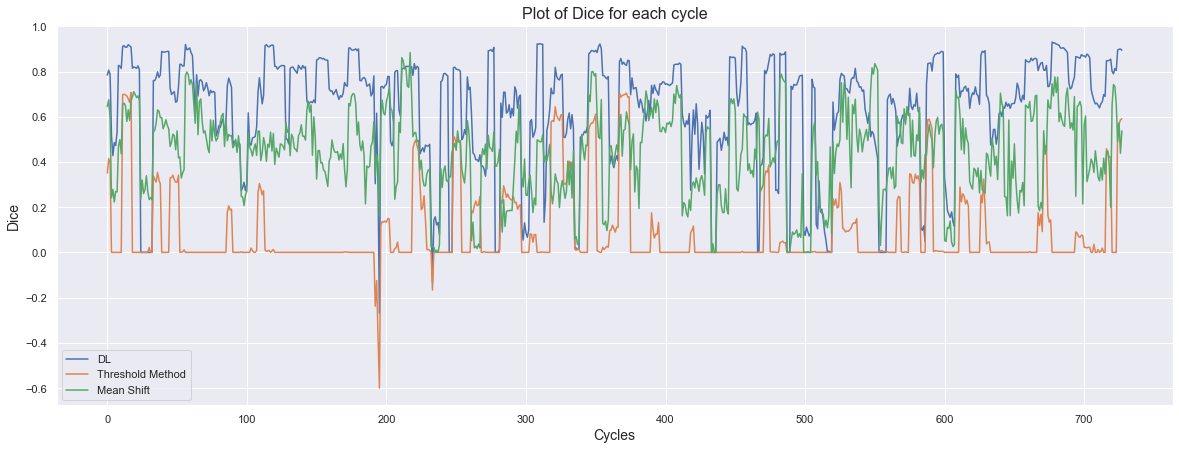

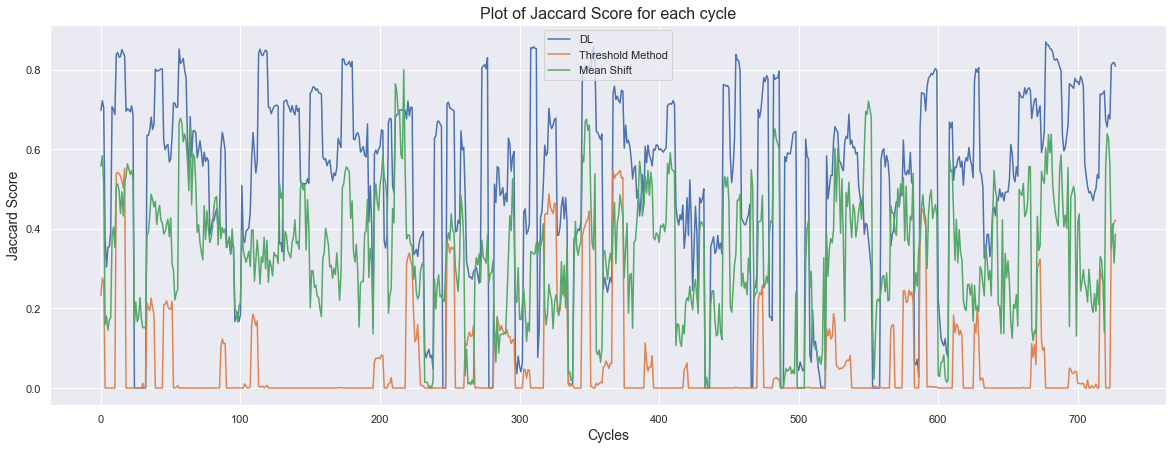

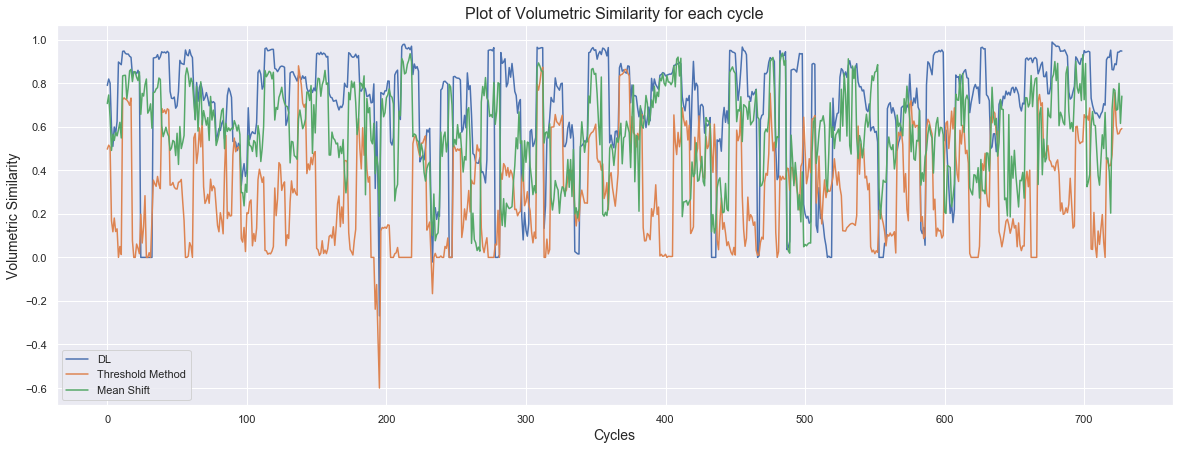

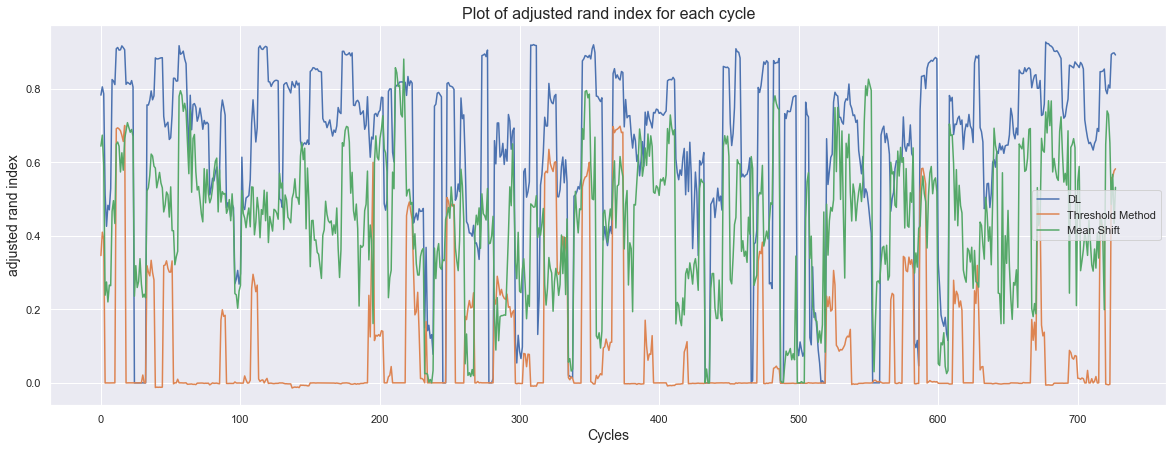

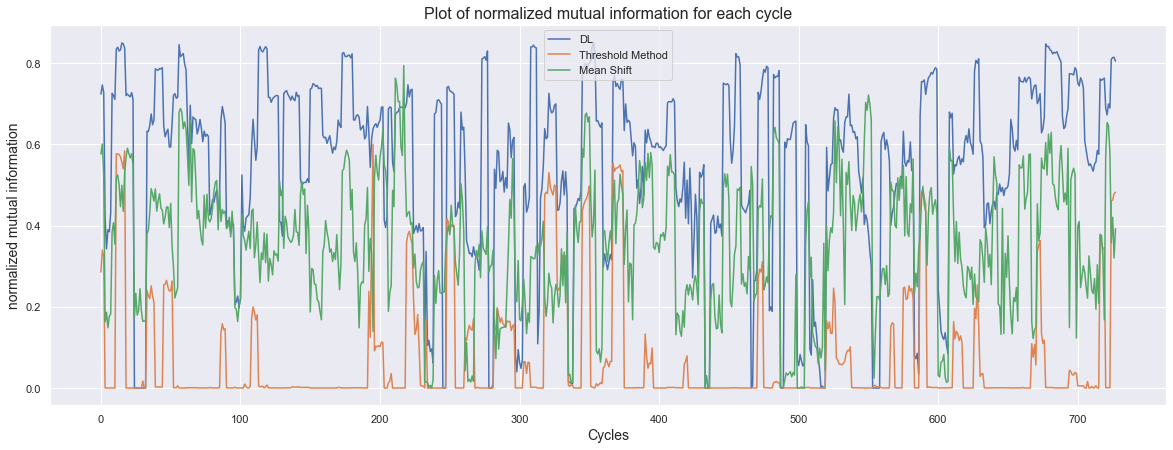

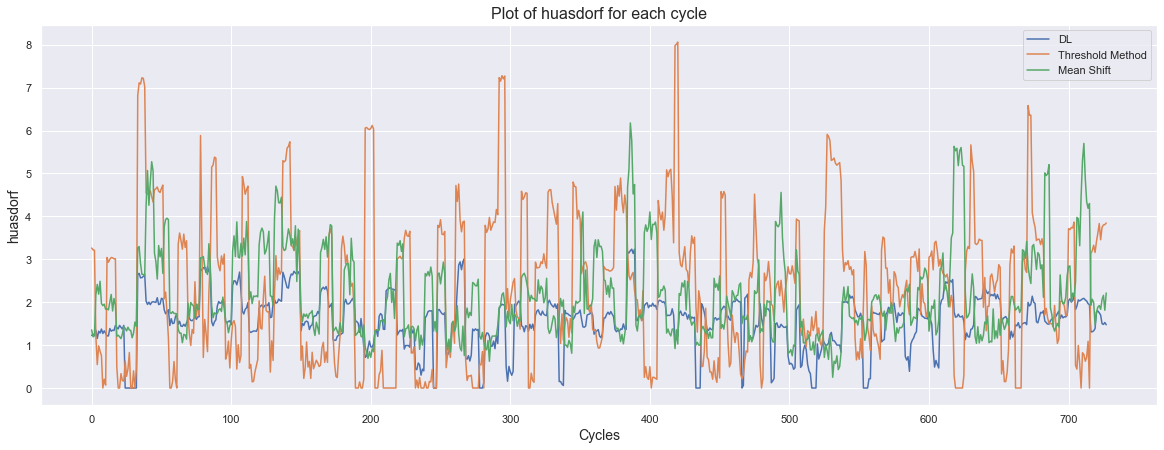

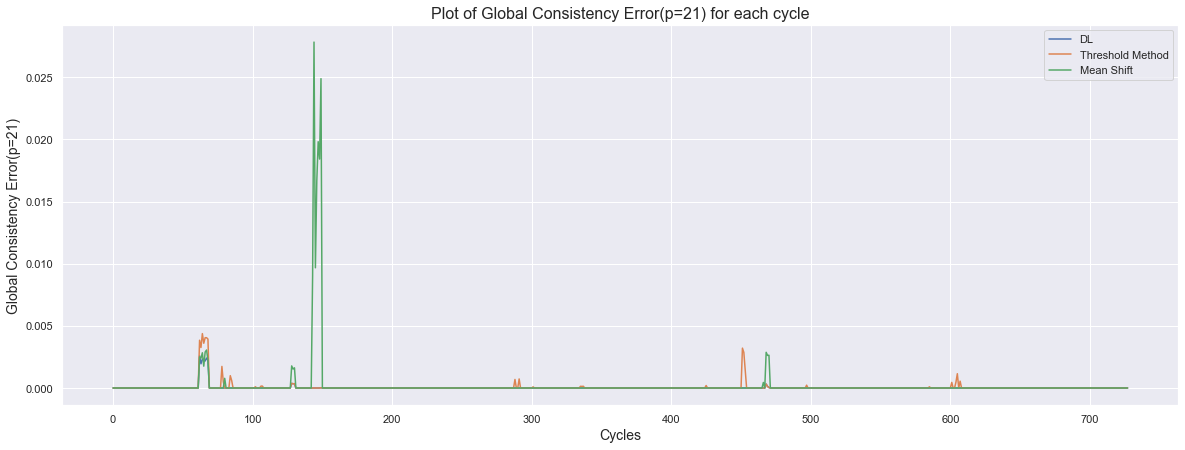

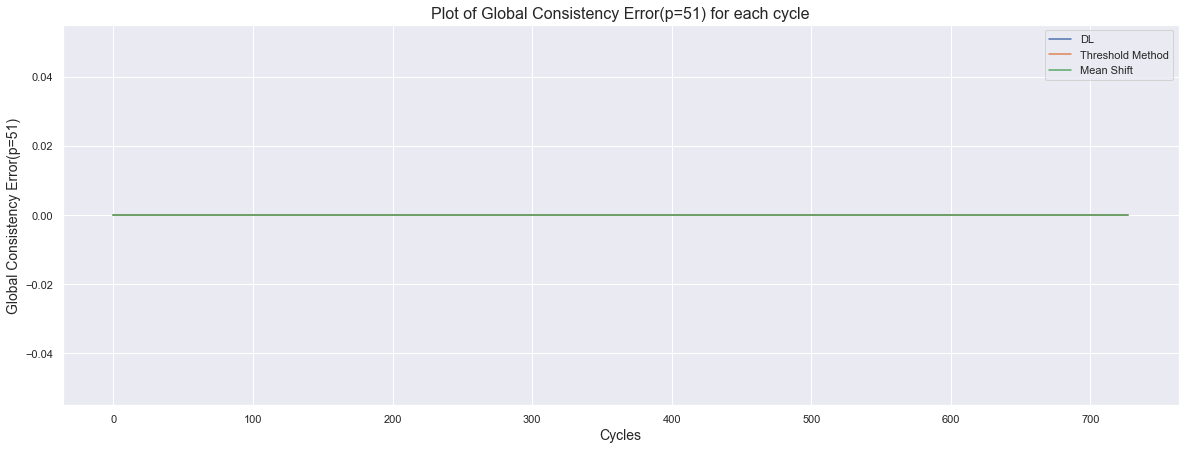

In [30]:
for ch in data1.columns[:-1]:
    plt.figure(figsize=(20,7))
    plt.title('Plot of '+ ch + ' for each cycle',fontsize = 16)
    plt.xlabel('Cycles',fontsize = 14)
    plt.ylabel(ch,fontsize = 14)
    ax =data1[ch].plot(kind='line')
    ax =data2[ch].plot(kind='line')
    ax =data3[ch].plot(kind='line')
    ax.legend(['DL','Threshold Method','Mean Shift'])
    plt.show()

In [36]:
Info = data.groupby('Method').agg(['mean','std']).round(2)
Info1 = data[['Dice','Jaccard Score','Volumetric Similarity','adjusted rand index','normalized mutual information','Method']].groupby('Method').agg(['mean']).T
Info2 = data[['huasdorf','Method']].groupby('Method').agg(['mean']).T

In [39]:
xx = Info.copy()
xx.columns = xx.columns.swaplevel(1 , 0)
xx = xx.T.sort_index().T

In [40]:
xx.to_excel('MeanStd.xlsx')

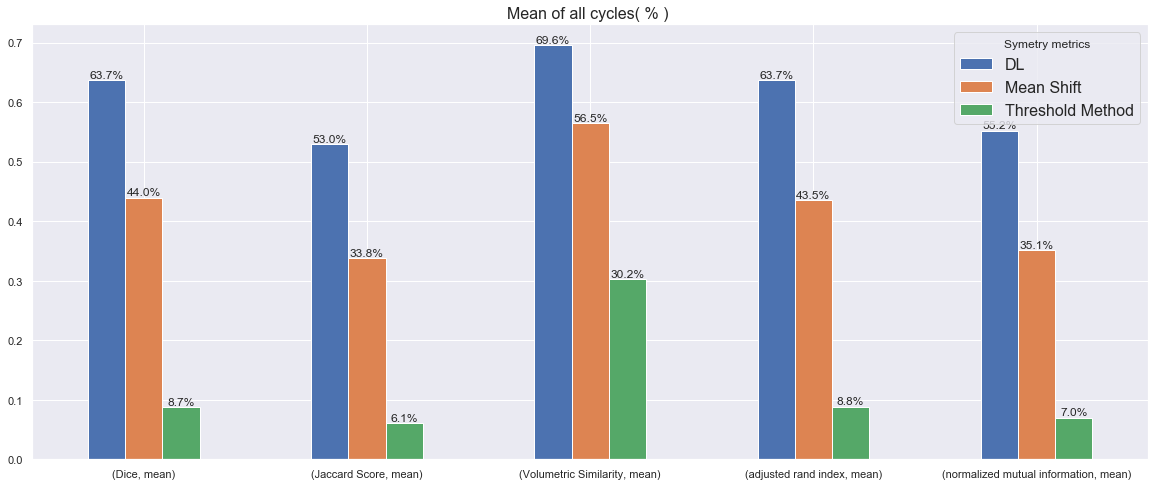

In [32]:
ax = Info1.plot.bar(rot=0,figsize=(20,8))
plt.legend(title='Symetry metrics',fontsize=16,fancybox=True)
plt.title('Mean of all cycles( % ) ',fontsize=16)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y), (x.mean(), y), 
            ha='center', va='bottom') 
    
plt.show()

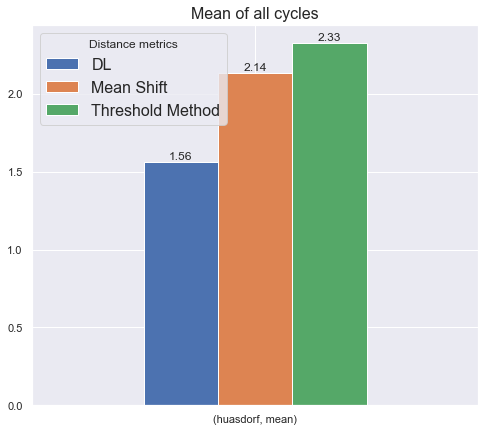

In [35]:
ax= Info2.plot.bar(rot=0,figsize=(8,7))
plt.legend(title='Distance metrics',fontsize=16,fancybox=True)
plt.title('Mean of all cycles',fontsize=16)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') 
plt.show()